In [181]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE

import warnings

%matplotlib inline

In [3]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input\collision_dataset.csv
input\README.txt


In [6]:
data = pd.read_csv("input/collision_dataset.csv")
print ("Dataset Shape {}".format(data.shape))

Dataset Shape (286424, 70)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286424 entries, 0 to 286423
Data columns (total 70 columns):
label                        286424 non-null object
driver_id                    286424 non-null object
event_dt                     286424 non-null object
industry                     286424 non-null object
trigger_type_12_cnt          286424 non-null int64
trigger_type_22_cnt          286424 non-null int64
trigger_sub_type_1015_cnt    286424 non-null int64
trigger_sub_type_1016_cnt    286424 non-null int64
trigger_sub_type_1018_cnt    286424 non-null int64
trigger_sub_type_39_cnt      286424 non-null int64
trigger_sub_type_51_cnt      286424 non-null int64
trigger_sub_type_52_cnt      286424 non-null int64
trigger_sub_type_53_cnt      286424 non-null int64
trigger_sub_type_57_cnt      286424 non-null int64
trigger_sub_type_123_cnt     286424 non-null int64
trigger_sub_type_1019_cnt    286424 non-null int64
trigger_sub_type_1026_cnt    286424 non-null int64
trigger_sub_type_1

In [9]:
data.isna().sum()[data.isna().sum() > 0] # There is no missing value

Series([], dtype: int64)

In [10]:
data['label'].describe() # Imbalanced Dataset

count     286424
unique         2
top          neg
freq      250000
Name: label, dtype: object

In [16]:
data['label'][data['label'] == 'neg'] = 0
data['label'][data['label'] == 'pos'] = 1
data.head()

,label,driver_id,event_dt,industry,trigger_type_12_cnt,trigger_type_22_cnt,trigger_sub_type_1015_cnt,trigger_sub_type_1016_cnt,trigger_sub_type_1018_cnt,trigger_sub_type_39_cnt,...,behavior_87_cnt,behavior_88_cnt,behavior_89_cnt,behavior_90_cnt,behavior_116_cnt,behavior_119_cnt,behavior_120_cnt,behavior_121_cnt,behavior_122_cnt,behavior_123_cnt
0,1,0000FFFF-0000-0200-E0C8-628E40EE0000,7/13/2017,industry_5,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0000FFFF-0000-0400-DC1A-628E40EE0000,8/18/2017,industry_0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0000FFFF-0000-0500-8242-628E40EE0000,12/1/2017,industry_3,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,7868242D-CB7B-E411-B9DB-02215E5EED57,10/16/2017,industry_2,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,0,0000FFFF-0000-0200-1A79-628E40EE0000,6/6/2017,industry_3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
lst_data = []
for col in data.columns:
    if data[col].nunique() == 1:
        lst_data.append(col)
        print ("Column {} has Single Unique Value".format(col))

Column behavior_120_cnt has Single Unique Value
Column behavior_121_cnt has Single Unique Value
Column behavior_123_cnt has Single Unique Value


In [19]:
# Check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = data.corr().abs()
corr_matrix.head()

# Nan means there is a single unique value (either 1 or 0) in that column

,trigger_type_12_cnt,trigger_type_22_cnt,trigger_sub_type_1015_cnt,trigger_sub_type_1016_cnt,trigger_sub_type_1018_cnt,trigger_sub_type_39_cnt,trigger_sub_type_51_cnt,trigger_sub_type_52_cnt,trigger_sub_type_53_cnt,trigger_sub_type_57_cnt,...,behavior_87_cnt,behavior_88_cnt,behavior_89_cnt,behavior_90_cnt,behavior_116_cnt,behavior_119_cnt,behavior_120_cnt,behavior_121_cnt,behavior_122_cnt,behavior_123_cnt
trigger_type_12_cnt,1.000000,0.139147,0.136733,0.208465,0.174456,0.015849,0.002659,0.029781,0.038352,0.026413,...,0.017714,0.004501,0.012341,0.012559,0.006587,0.000645,NaN,NaN,0.618139,NaN
trigger_type_22_cnt,0.139147,1.000000,0.238927,0.174805,0.198252,0.025143,0.061393,0.072004,0.092894,0.047148,...,0.013029,0.000154,0.007975,0.057005,0.004993,0.021098,NaN,NaN,0.435128,NaN
trigger_sub_type_1015_cnt,0.136733,0.238927,1.000000,0.441773,0.568190,0.020767,0.012772,0.110347,0.225607,0.054364,...,0.056785,0.010921,0.000180,0.054051,0.007276,0.019199,NaN,NaN,0.170412,NaN
trigger_sub_type_1016_cnt,0.208465,0.174805,0.441773,1.000000,0.628447,0.041480,0.033821,0.078267,0.144793,0.058945,...,0.033263,0.007696,0.003350,0.037411,0.009776,0.009463,NaN,NaN,0.203109,NaN
trigger_sub_type_1018_cnt,0.174456,0.198252,0.568190,0.628447,1.000000,0.040858,0.038174,0.101303,0.175759,0.066640,...,0.005766,0.011196,0.017455,0.053412,0.007602,0.014637,NaN,NaN,0.192171,NaN


In [20]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,trigger_type_12_cnt,trigger_type_22_cnt,trigger_sub_type_1015_cnt,trigger_sub_type_1016_cnt,trigger_sub_type_1018_cnt,trigger_sub_type_39_cnt,trigger_sub_type_51_cnt,trigger_sub_type_52_cnt,trigger_sub_type_53_cnt,trigger_sub_type_57_cnt,...,behavior_87_cnt,behavior_88_cnt,behavior_89_cnt,behavior_90_cnt,behavior_116_cnt,behavior_119_cnt,behavior_120_cnt,behavior_121_cnt,behavior_122_cnt,behavior_123_cnt
trigger_type_12_cnt,NaN,0.139147,0.136733,0.208465,0.174456,0.015849,0.002659,0.029781,0.038352,0.026413,...,0.017714,0.004501,0.012341,0.012559,0.006587,0.000645,NaN,NaN,0.618139,NaN
trigger_type_22_cnt,NaN,NaN,0.238927,0.174805,0.198252,0.025143,0.061393,0.072004,0.092894,0.047148,...,0.013029,0.000154,0.007975,0.057005,0.004993,0.021098,NaN,NaN,0.435128,NaN
trigger_sub_type_1015_cnt,NaN,NaN,NaN,0.441773,0.568190,0.020767,0.012772,0.110347,0.225607,0.054364,...,0.056785,0.010921,0.000180,0.054051,0.007276,0.019199,NaN,NaN,0.170412,NaN
trigger_sub_type_1016_cnt,NaN,NaN,NaN,NaN,0.628447,0.041480,0.033821,0.078267,0.144793,0.058945,...,0.033263,0.007696,0.003350,0.037411,0.009776,0.009463,NaN,NaN,0.203109,NaN
trigger_sub_type_1018_cnt,NaN,NaN,NaN,NaN,NaN,0.040858,0.038174,0.101303,0.175759,0.066640,...,0.005766,0.011196,0.017455,0.053412,0.007602,0.014637,NaN,NaN,0.192171,NaN


In [21]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

There are 1 columns to remove.
Following columns can be dropped ['trigger_sub_type_123_cnt']


In [22]:
data = data.drop(columns = to_drop) # Drop 'trigger_sub_type_123_cnt'

In [23]:
# Column behavior_120_cnt has Single Unique Value
# Column behavior_121_cnt has Single Unique Value
# Column behavior_123_cnt has Single Unique Value
data.drop(['behavior_120_cnt', 'behavior_121_cnt', 'behavior_123_cnt'],axis=1,inplace=True)

In [25]:
# First drop driver_id, event_dt, industry (string value)
data.drop(['driver_id', 'event_dt', 'industry'],axis=1,inplace=True)

In [28]:
X = data[[col for col in data.columns if col!='label']]
Y = data['label']

In [125]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

    
def plot_3d_space(X, y, label='Classes'):  
    ax = plt.axes(projection='3d')
    colors = ['#1F77B4', '#FF7F0E', '#99ff66']
    markers = ['o', 's', '+']
    for l, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(
            X[y==l, 0],
            X[y==l, 1],
            X[y==1, 2],
            c=c, label=l, marker=m
        )
    ax.title(label)
    ax.legend(loc='upper right')
    plt.show()

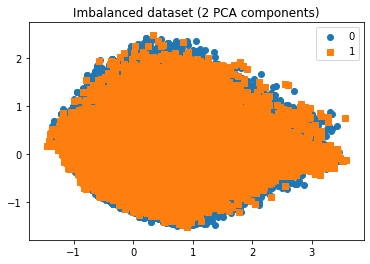

In [119]:
pca = PCA(n_components=2)
pca_sx = pca.fit_transform(X)

plot_2d_space(pca_sx, Y, 'Imbalanced dataset (2 PCA components)')

In [ ]:
# X_reduced_tsne = TSNE(n_components=2, random_state=19960214).fit_transform(X)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Pos')
red_patch = mpatches.Patch(color='#AF0000', label='Neg')
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y == 0), cmap='coolwarm', label='Neg', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()

In [29]:
rf = RandomForestRegressor(n_jobs=-1,random_state=19960214)
rf.fit(X,Y)

c:\users\zhuor\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=19960214, verbose=0,
                      warm_start=False)

In [30]:
feature_importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances

,feature,importance
29,behavior_47_cnt,0.101685
41,behavior_69_cnt,0.041281
24,behavior_29_cnt,0.039280
6,trigger_sub_type_51_cnt,0.036320
32,behavior_59_cnt,0.034866
...,...,...
39,behavior_66_cnt,0.000444
48,behavior_79_cnt,0.000405
30,behavior_56_cnt,0.000343
17,behavior_12_cnt,0.000106


In [32]:
rf_2 = RandomForestRegressor(n_jobs=-1,random_state=42)
params = {"n_estimators":list(range(50,501,100)),
          "max_features":[0.5,'sqrt','log2'],
          "min_samples_leaf":[1,3,5,10,25],
          "min_samples_split":[2,5,7,10,15],
          "max_depth":[3,5,7,9]}
r_search = RandomizedSearchCV(estimator=rf_2,param_distributions=params,cv=5,scoring='r2')
r_search.fit(X,Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [33]:
r_search.best_estimator_,r_search.best_params_,r_search.best_score_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                       max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False),
 {'n_estimators': 450,
  'min_samples_split': 2,
  'min_samples_leaf': 5,
  'max_features': 0.5,
  'max_depth': 7},
 0.09068978651456995)

In [34]:
feature_importances = r_search.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances

,feature,importance
29,behavior_47_cnt,6.503937e-01
5,trigger_sub_type_39_cnt,6.589235e-02
28,behavior_46_cnt,6.435440e-02
55,behavior_87_cnt,2.921403e-02
27,behavior_45_cnt,2.257628e-02
...,...,...
56,behavior_88_cnt,2.885765e-05
48,behavior_79_cnt,1.895611e-05
43,behavior_74_cnt,1.863461e-05
30,behavior_56_cnt,2.306320e-06


In [141]:
sx, sy = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1009, random_state=19960214
)

In [145]:
sx.shape, sy.shape

((1009, 20), (1009,))

In [146]:
X.shape, Y.shape

((286424, 62), (286424,))

In [149]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, Y)

In [150]:
X_sm.shape, y_sm.shape

((500000, 62), (500000,))

In [153]:
unique, counts = np.unique(y_sm, return_counts=True)
dict(zip(unique, counts))

{0: 250000, 1: 250000}

In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=19960214)

In [154]:
xsm_train, xsm_valid, ysm_train, ysm_valid = train_test_split(X_sm, y_sm, test_size=0.2, random_state=19960214)

In [155]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
dsm_train = xgb.DMatrix(xsm_train, label=ysm_train)
dsm_valid = xgb.DMatrix(xsm_valid, label=ysm_valid)

c:\users\zhuor\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [156]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

xgb_params = {
    'n_trees': 520, 
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.98,
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'base_score': np.mean(y_train), # base prediction = mean(target)
    'silent': 1
}

In [157]:
watchlist = [(dsm_train, 'train'), (dsm_valid, 'valid')]
clf = xgb.train(xgb_params, dsm_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=500)

[0]	train-auc:0.649458	valid-auc:0.648795
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[500]	train-auc:0.689967	valid-auc:0.689928
[1000]	train-auc:0.699448	valid-auc:0.69909
[1500]	train-auc:0.704983	valid-auc:0.704331
[2000]	train-auc:0.708268	valid-auc:0.70735
[2500]	train-auc:0.710454	valid-auc:0.709383
[3000]	train-auc:0.712451	valid-auc:0.7113
[3500]	train-auc:0.714054	valid-auc:0.7127
[4000]	train-auc:0.715453	valid-auc:0.713934
[4500]	train-auc:0.716674	valid-auc:0.715006
[5000]	train-auc:0.717737	valid-auc:0.715868
[5500]	train-auc:0.718843	valid-auc:0.716845
[6000]	train-auc:0.719818	valid-auc:0.717679
[6500]	train-auc:0.720781	valid-auc:0.718529
[7000]	train-auc:0.721598	valid-auc:0.719148
[7500]	train-auc:0.722498	valid-auc:0.719954
[8000]	train-auc:0.723468	valid-auc:0.720765
[8500]	train-auc:0.724257	valid-auc:0.721411
[9000]	train-auc:0.724978	valid-auc:0.722017
[9500]	trai

In [62]:
"""
Training Without Data Sampling.

[0]	train-auc:0.660542	valid-auc:0.666065
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[500]	train-auc:0.694256	valid-auc:0.694405
[1000]	train-auc:0.703119	valid-auc:0.70128
[1500]	train-auc:0.707017	valid-auc:0.703837
[2000]	train-auc:0.709427	valid-auc:0.705402
[2500]	train-auc:0.711024	valid-auc:0.70618
[3000]	train-auc:0.712578	valid-auc:0.706756
[3500]	train-auc:0.713797	valid-auc:0.706996
[4000]	train-auc:0.714896	valid-auc:0.707214
[4500]	train-auc:0.71584	valid-auc:0.707464
[5000]	train-auc:0.71662	valid-auc:0.707653
Stopping. Best iteration:
[5044]	train-auc:0.716687	valid-auc:0.707704

Training with SMOTE Sampling

[0]	train-auc:0.649458	valid-auc:0.648795
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[500]	train-auc:0.689967	valid-auc:0.689928
[1000]	train-auc:0.699448	valid-auc:0.69909
[1500]	train-auc:0.704983	valid-auc:0.704331
[2000]	train-auc:0.708268	valid-auc:0.70735
[2500]	train-auc:0.710454	valid-auc:0.709383
[3000]	train-auc:0.712451	valid-auc:0.7113
[3500]	train-auc:0.714054	valid-auc:0.7127
[4000]	train-auc:0.715453	valid-auc:0.713934
[4500]	train-auc:0.716674	valid-auc:0.715006
[5000]	train-auc:0.717737	valid-auc:0.715868
[5500]	train-auc:0.718843	valid-auc:0.716845
[6000]	train-auc:0.719818	valid-auc:0.717679
[6500]	train-auc:0.720781	valid-auc:0.718529
[7000]	train-auc:0.721598	valid-auc:0.719148
[7500]	train-auc:0.722498	valid-auc:0.719954
[8000]	train-auc:0.723468	valid-auc:0.720765
[8500]	train-auc:0.724257	valid-auc:0.721411
[9000]	train-auc:0.724978	valid-auc:0.722017
[9500]	train-auc:0.72563	valid-auc:0.722516
[9999]	train-auc:0.726328	valid-auc:0.723071
"""

"\n[0]\ttrain-auc:0.660542\tvalid-auc:0.666065\nMultiple eval metrics have been passed: 'valid-auc' will be used for early stopping.\n\nWill train until valid-auc hasn't improved in 100 rounds.\n[500]\ttrain-auc:0.694256\tvalid-auc:0.694405\n[1000]\ttrain-auc:0.703119\tvalid-auc:0.70128\n[1500]\ttrain-auc:0.707017\tvalid-auc:0.703837\n[2000]\ttrain-auc:0.709427\tvalid-auc:0.705402\n[2500]\ttrain-auc:0.711024\tvalid-auc:0.70618\n[3000]\ttrain-auc:0.712578\tvalid-auc:0.706756\n[3500]\ttrain-auc:0.713797\tvalid-auc:0.706996\n[4000]\ttrain-auc:0.714896\tvalid-auc:0.707214\n[4500]\ttrain-auc:0.71584\tvalid-auc:0.707464\n[5000]\ttrain-auc:0.71662\tvalid-auc:0.707653\nStopping. Best iteration:\n[5044]\ttrain-auc:0.716687\tvalid-auc:0.707704\n"

In [ ]:
y_pred = clf.predict(xsm_valid)
predictions = [round(value) for value in y_pred]
f_s = f1_score(ysm_valid, predictions)
print(f_s)

In [104]:
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [159]:
def auc_roc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [176]:
def build_model(input_dims):
    model = Sequential()

    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(input_dims//4, activation='relu'))
    
    # output layer (y_pred)
    model.add(Dense(1, activation='softmax'))
    
    # compile this model
    model.compile(loss='binary_crossentropy', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam',
                  metrics=[f1] # you can add several if needed
                 )
    
    # Visualize NN architecture
    print(model.summary())
    return model

In [177]:
model_path = 'keras_model.h5'

my_callbacks = [EarlyStopping(monitor='f1', patience=10, verbose=1, mode='max')]

In [178]:
model = build_model(xsm_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 62)                3906      
_________________________________________________________________
batch_normalization_43 (Batc (None, 62)                248       
_________________________________________________________________
activation_43 (Activation)   (None, 62)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 62)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 62)                3906      
_________________________________________________________________
batch_normalization_44 (Batc (None, 62)                248       
_________________________________________________________________
activation_44 (Activation)   (None, 62)                0         
__________

In [179]:
model.fit(xsm_train, ysm_train,
          validation_data=(xsm_valid, ysm_valid),
          batch_size=32, nb_epoch=50, verbose=1,
          callbacks=my_callbacks)

c:\users\zhuor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 400000 samples, validate on 100000 samples
Epoch 1/50
194944/400000 [=============>................] - ETA: 26s - loss: 7.9705 - f1: 0.6620

KeyboardInterrupt: 

In [ ]:
"""

Train on 400000 samples, validate on 100000 samples
Epoch 1/500
400000/400000 [==============================] - 47s 117us/step - loss: 0.8520 - f1: 0.4939 - val_loss: 0.6434 - val_f1: 0.6083
Epoch 2/500
400000/400000 [==============================] - 44s 109us/step - loss: 0.6496 - f1: 0.5963 - val_loss: 0.6347 - val_f1: 0.6403
Epoch 3/500
400000/400000 [==============================] - 45s 113us/step - loss: 0.6371 - f1: 0.6279 - val_loss: 0.6318 - val_f1: 0.6340
Epoch 4/500
400000/400000 [==============================] - 48s 121us/step - loss: 0.6333 - f1: 0.6301 - val_loss: 0.6335 - val_f1: 0.6364
Epoch 5/500
400000/400000 [==============================] - 47s 118us/step - loss: 0.6310 - f1: 0.6276 - val_loss: 0.6310 - val_f1: 0.6376
Epoch 6/500
400000/400000 [==============================] - 45s 113us/step - loss: 0.6297 - f1: 0.6315 - val_loss: 0.6319 - val_f1: 0.6443
Epoch 7/500
400000/400000 [==============================] - 45s 111us/step - loss: 0.6287 - f1: 0.6316 - val_loss: 0.6303 - val_f1: 0.6404
Epoch 8/500
400000/400000 [==============================] - 45s 112us/step - loss: 0.6288 - f1: 0.6301 - val_loss: 0.6295 - val_f1: 0.6602
Epoch 9/500
400000/400000 [==============================] - 46s 116us/step - loss: 0.6277 - f1: 0.6362 - val_loss: 0.6314 - val_f1: 0.6675
Epoch 10/500
400000/400000 [==============================] - 45s 112us/step - loss: 0.6270 - f1: 0.6347 - val_loss: 0.6313 - val_f1: 0.6742
Epoch 11/500
400000/400000 [==============================] - 45s 112us/step - loss: 0.6271 - f1: 0.6374 - val_loss: 0.6363 - val_f1: 0.6785
Epoch 12/500
400000/400000 [==============================] - 45s 112us/step - loss: 0.6261 - f1: 0.6375 - val_loss: 0.6367 - val_f1: 0.6725
Epoch 13/500
400000/400000 [==============================] - 46s 114us/step - loss: 0.6261 - f1: 0.6369 - val_loss: 0.6293 - val_f1: 0.6694
Epoch 14/500
400000/400000 [==============================] - 44s 111us/step - loss: 0.6257 - f1: 0.6386 - val_loss: 0.6355 - val_f1: 0.6795
Epoch 15/500
400000/400000 [==============================] - 47s 117us/step - loss: 0.6257 - f1: 0.6377 - val_loss: 0.6305 - val_f1: 0.6684
Epoch 16/500
400000/400000 [==============================] - 43s 107us/step - loss: 0.6253 - f1: 0.6361 - val_loss: 0.6362 - val_f1: 0.6810
Epoch 17/500
400000/400000 [==============================] - 47s 117us/step - loss: 0.6248 - f1: 0.6370 - val_loss: 0.6366 - val_f1: 0.6810
Epoch 18/500
400000/400000 [==============================] - 45s 111us/step - loss: 0.6241 - f1: 0.6353 - val_loss: 0.6307 - val_f1: 0.6736
Epoch 19/500
400000/400000 [==============================] - 44s 111us/step - loss: 0.6249 - f1: 0.6362 - val_loss: 0.6356 - val_f1: 0.6826
Epoch 20/500
400000/400000 [==============================] - 40s 100us/step - loss: 0.6246 - f1: 0.6362 - val_loss: 0.6386 - val_f1: 0.6808
Epoch 21/500
400000/400000 [==============================] - 40s 99us/step - loss: 0.6251 - f1: 0.6331 - val_loss: 0.6292 - val_f1: 0.6647
Epoch 22/500
400000/400000 [==============================] - 41s 102us/step - loss: 0.6238 - f1: 0.6354 - val_loss: 0.6362 - val_f1: 0.6829
Epoch 23/500
400000/400000 [==============================] - 40s 99us/step - loss: 0.6248 - f1: 0.6360 - val_loss: 0.6356 - val_f1: 0.6764
Epoch 24/500
400000/400000 [==============================] - 38s 95us/step - loss: 0.6243 - f1: 0.6340 - val_loss: 0.6360 - val_f1: 0.6809
Epoch 25/500
400000/400000 [==============================] - 40s 101us/step - loss: 0.6241 - f1: 0.6348 - val_loss: 0.6333 - val_f1: 0.6768
Epoch 26/500
400000/400000 [==============================] - 40s 100us/step - loss: 0.6236 - f1: 0.6379 - val_loss: 0.6371 - val_f1: 0.6817
Epoch 27/500
400000/400000 [==============================] - 39s 98us/step - loss: 0.6245 - f1: 0.6351 - val_loss: 0.6375 - val_f1: 0.6816

"""